In [1]:
import meshio
import torch
import torch_geometric
from torch_geometric.data import Data
from torch_geometric.utils import to_undirected
from torch_geometric.transforms import FaceToEdge
import matplotlib.pyplot as plt

In [2]:
class TetraToEdge(object):
    r"""Converts mesh tetras :obj:`[4, num_tetras]` to edge indices
    :obj:`[2, num_edges]`.
    Args:
        remove_tetras (bool, optional): If set to :obj:`False`, the tetra tensor
            will not be removed.
    """

    def __init__(self, remove_tetras=True):
        self.remove_tetras = remove_tetras

    def __call__(self, data):
        if data.tetra is not None:
            tetra = data.tetra
            edge_index = torch.cat([tetra[:2], tetra[1:3, :], tetra[-2:], tetra[::2], tetra[::3], tetra[1::2]], dim=1)
            edge_index = to_undirected(edge_index, num_nodes=data.num_nodes)

            data.edge_index = edge_index
            if self.remove_tetras:
                data.tetra = None

        return data

    def __repr__(self):
        return '{}()'.format(self.__class__.__name__)

In [3]:
def from_meshio(mesh, mesh_type='2D'):
    r"""Converts a :.msh file to a
    :class:`torch_geometric.data.Data` instance.

    Args:
        mesh (meshio.read): A :obj:`meshio` mesh.
    """

    if meshio is None:
        raise ImportError('Package `meshio` could not be found.')

    pos = torch.from_numpy(mesh.points).to(torch.float)
    if mesh_type == '3D':
        tetra = torch.from_numpy(mesh.cells_dict['tetra']).to(torch.long).t().contiguous()
        return Data(pos=pos, tetra=tetra)
    elif mesh_type == '2D':
        face = torch.from_numpy(mesh.cells_dict['triangle']).to(torch.long).t().contiguous()
        return Data(pos=pos, face=face)

In [4]:
mesh_type = '2D'
filename = '../meshes/hole_coarse.msh'

mesh = meshio.read(filename)

data = from_meshio(mesh, mesh_type=mesh_type)
if mesh_type == '2D':
    data = FaceToEdge(remove_faces=False)(data)
else:
    data = TetraToEdge()(data)

# These are the rays
o = torch.tensor([[0.5, 0.5, 0.], [0.2, -0.5, 0.]])
d = torch.tensor([[-1., -1., 0.], [-1., 0.8, 0.]])

data.n_index = torch.ones((data.face.shape[1]))

#### 1. Distancia R0 - Bi

Primero sacamos las coordenadas de cada triángulo. Debería ser [Num triángulos, 3 (vértices), 3 (coordenadas)]

In [5]:
triangles = data.face.permute(1, 0)

In [6]:
triangles.shape

torch.Size([395, 3])

In [7]:
triangles_coords = data.pos[triangles]

In [8]:
triangles_coords.shape

torch.Size([395, 3, 3])

Después el centroide de cada uno y lo guardamos en el data

In [9]:
centroids = torch.sum(triangles_coords, dim=1) / 3

In [10]:
data.centroids = centroids

In [11]:
data.centroids.shape

torch.Size([395, 3])

In [12]:
def calculate_centroids(graph):
    triangles = graph.face.permute(1, 0)
    triangles_coords = graph.pos[triangles]
    graph.centroids = torch.sum(triangles_coords, dim=1) / 3
    return graph

Comprobamos que es un centro

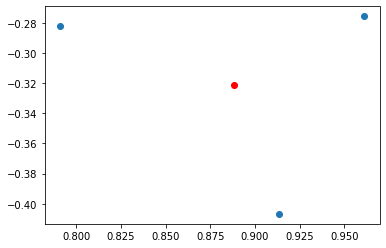

In [13]:
plt.scatter(triangles_coords[0,:,0], triangles_coords[0,:,1])
plt.scatter(centroids[0,0], centroids[0,1], color='red')

Calculamos la distancia desde el origen del rayo a cada centroide

In [14]:
(data.centroids - o.unsqueeze(1)).shape

torch.Size([2, 395, 3])

In [15]:
dist_r_c = torch.norm(data.centroids - o.unsqueeze(1), dim=-1)

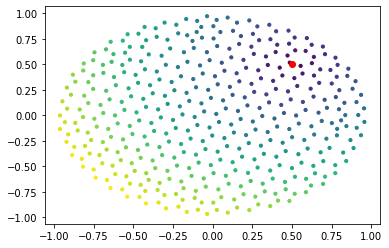

In [16]:
plt.scatter(centroids[:,0], centroids[:,1], c=dist_r_c[0], s=10)
plt.scatter(o[0, 0], o[0, 1], color='red')

Todo tiene sentido.

#### 2. Sacar el triángulo en el que nos encontramos

In [17]:
dist_r_c.shape

torch.Size([2, 395])

In [18]:
o_triangle = dist_r_c.argmin(1)

In [19]:
o_triangle

tensor([120, 243])

In [20]:
triangles_coords[o_triangle,:,:2]

tensor([[[ 0.4968,  0.4403],
         [ 0.5548,  0.5626],
         [ 0.4082,  0.5433]],

        [[ 0.1615, -0.6178],
         [ 0.2041, -0.4854],
         [ 0.0663, -0.5139]]])

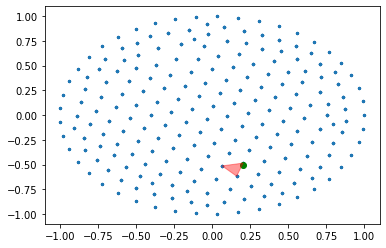

In [21]:
plt.figure()
plt.scatter(triangles_coords[:,:,0], triangles_coords[:,:,1], s=5)

t1 = plt.Polygon(triangles_coords[o_triangle,:,:2][1], color='red', alpha=0.4)
plt.gca().add_patch(t1)
plt.scatter(o[1,0], o[1,1], color='green')

In [22]:
def get_triangle_origin(origin, graph):
    dist_r_c = torch.norm(graph.centroids - o.unsqueeze(1), dim=-1)
    o_triangle = dist_r_c.argmin(1)
    return o_triangle

#### 3. Intersección de Rd con las aristas y determinación del siguiente triángulo

In [23]:
import numpy as np
from itertools import combinations

In [24]:
def line_ray_intersection_point(rayOrigin, rayDirection, point1, point2):
    # Ray-Line Segment Intersection Test in 2D
    # http://bit.ly/1CoxdrG
    """
    t1: Parametrization of the ray
    t2: Parametrization of the segment defined by point1 and point2
    """


    v1 = (rayOrigin - point1)[:,:-1]
    v2 = (point2 - point1)[:,:-1]
    v3 = np.stack([-np.array(rayDirection[:, 1]), np.array(rayDirection[:, 0])], axis=1)
    dotprod = np.einsum('ij, ij -> i', v2, v3)
    t1 = np.cross(v2, v1, axis=1) / dotprod
    t2 = np.einsum('ij, ij -> i', v1, v3) / dotprod
    intersection_bool = torch.tensor((t1 >= 0) * (t2 >= 0) * (t2 <= 1))
    return intersection_bool, torch.tensor(t1), torch.tensor(t2)

In [25]:
def get_point_parametrization(a, b, t):
    return a + (b - a)*t.unsqueeze(1)

In [26]:
idx_vertex_origin_triangle = triangles[o_triangle]
vertex_origin_triangle = triangles_coords[o_triangle]  # Only for plotting

In [27]:
idx_vertex_origin_triangle

tensor([[165, 166, 124],
        [ 64,  67,  66]])

El rayo puede que no haya caído en el triángulo exacto, así que puede chocar dos veces. Hay que tomar el punto más lejano

In [28]:
combs = [[0, 1, 2], [0, 2, 1], [1, 2, 0]]
idx_vertex = torch.zeros((o.shape[0], 2), dtype=torch.int64)  # Batch size
t1 = torch.zeros((o.shape[0]))
new_o = torch.zeros_like(o)
edge_vectors = torch.zeros((o.shape[0], 3))

for idx_p1, idx_p2, out in combs:
    p1 = data.pos[idx_vertex_origin_triangle[:, idx_p1]]
    p2 = data.pos[idx_vertex_origin_triangle[:, idx_p2]]
    
    intersection, t1_comb, t2_comb = line_ray_intersection_point(o, d, p1, p2)
    origin = get_point_parametrization(p1, p2, t2_comb)
    condition = intersection & (t1_comb > t1)
    condition_element = condition.unsqueeze(1).repeat(1,3)

    if condition.any():
        t1 = torch.where(condition, t1_comb, t1)
        #idx_vertex = torch.where(condition_element, idx_vertex_origin_triangle[:,[idx_p1, idx_p2]], idx_vertex)
        idx_vertex[condition] = idx_vertex_origin_triangle[:,[idx_p1, idx_p2]][condition]
        new_o[condition] = origin[condition]
        edge_vectors[condition] = (p2 - p1)[condition]
        #new_o = torch.where(condition_element, origin, new_o)
        #edge_vectors = torch.where(condition_element, p2 - p1, edge_vectors)

In [29]:
def find_edge_intersection(origin, direction, origin_triangle):
    idx_vertex_origin_triangle = triangles[origin_triangle]
    
    combs = [[0, 1, 2], [0, 2, 1], [1, 2, 0]]
    idx_vertex = torch.zeros((origin.shape[0], 2), dtype=torch.int64)  # Batch size
    t1 = torch.zeros((origin.shape[0]))
    new_origin = torch.zeros_like(origin)
    edge_vectors = torch.zeros((origin.shape[0], 3))

    for idx_p1, idx_p2, out in combs:
        p1 = data.pos[idx_vertex_origin_triangle[:, idx_p1]]
        p2 = data.pos[idx_vertex_origin_triangle[:, idx_p2]]

        intersection, t1_comb, t2_comb = line_ray_intersection_point(origin, d, p1, p2)
        new_origin_temp = get_point_parametrization(p1, p2, t2_comb)
        condition = intersection & (t1_comb > t1)
        condition_element = condition.unsqueeze(1).repeat(1,3)

        if condition.any():
            t1 = torch.where(condition, t1_comb, t1)
            idx_vertex[condition] = idx_vertex_origin_triangle[:,[idx_p1, idx_p2]][condition]
            new_origin[condition] = new_origin_temp[condition]
            edge_vectors[condition] = (p2 - p1)[condition]
            
    return idx_vertex, new_o, edge_vectors

In [30]:
idx_vertex, new_o, edge_vectors = find_edge_intersection(o, d, o_triangle)

In [31]:
edge_vectors

tensor([[-0.0886,  0.1031,  0.0000],
        [-0.1378, -0.0285,  0.0000]])

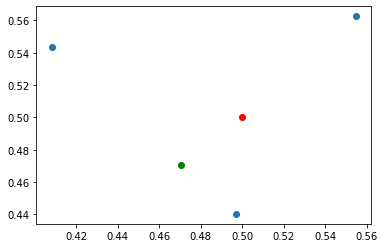

In [32]:
plt.scatter(vertex_origin_triangle[0,:,0], vertex_origin_triangle[0,:,1])
plt.scatter(o[0,0], o[0,1], color='red')
plt.scatter(new_o[0,0], new_o[0, 1], color='green')

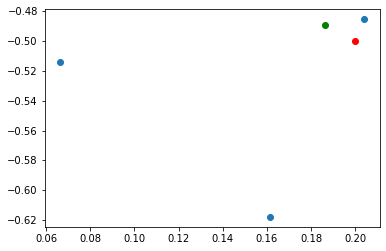

In [33]:
plt.scatter(vertex_origin_triangle[1,:,0], vertex_origin_triangle[1,:,1])
plt.scatter(o[1,0], o[1,1], color='red')
plt.scatter(new_o[1,0], new_o[1, 1], color='green')

- Sacar nuevo triángulo
- Ley de Snell para la nueva dirección
- Bucle de lo anterior

Determinación del siguiente triángulo. Esto es O(B)

In [34]:
next_triangle = torch.zeros((o.shape[0]), dtype=torch.long)
for i, r in enumerate(idx_vertex):
    next_triangle[i] = torch.nonzero((triangles == r[0]).any(1) * (triangles == r[1]).any(1) * 
                              (triangles != idx_vertex_origin_triangle[i]).any(1))[0,0]

In [35]:
next_triangle

tensor([119, 241])

In [36]:
def get_next_triangle(idx_vertex, idx_vertex_origin_triangle):
    next_triangle = torch.zeros((idx_vertex.shape[0]), dtype=torch.long)
    for i, r in enumerate(idx_vertex):
        next_triangle[i] = torch.nonzero((triangles == r[0]).any(1) * (triangles == r[1]).any(1) * 
                                  (triangles != idx_vertex_origin_triangle[i]).any(1))[0,0]
    return next_triangle

In [37]:
next_triangle = get_next_triangle(idx_vertex, idx_vertex_origin_triangle)

In [38]:
triangles_visited = o_triangle.clone().unsqueeze(1).long()
triangles_visited = torch.cat([triangles_visited, next_triangle.unsqueeze(1)], dim=-1)

#### 4. Nueva dirección

http://www.starkeffects.com/snells-law-vector.shtml

In [39]:
last_triangle = triangles_visited[:,-2]
current_triangle = triangles_visited[:,-1]

last_n = data.n_index[last_triangle]
current_n = data.n_index[current_triangle]

Hay que sacar la normal de la arista. Esta normal entra hacia el triángulo del que venimos.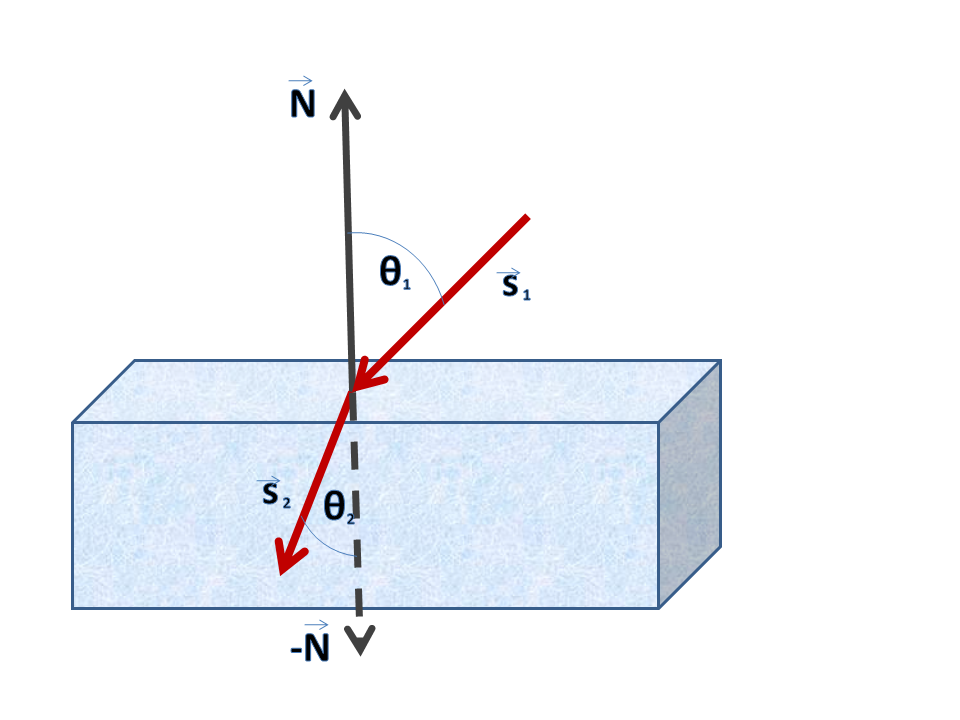

In [40]:
plane = torch.tensor([[0., 0., 1.]]*o.shape[0])

In [41]:
normal = torch.cross(plane, edge_vectors, dim=1)
normal = torch.nn.functional.normalize(normal, dim=1)

La normal va en la dirección contraria al rayo

In [42]:
normal_condition = torch.einsum('bi,bi->b', normal, d) > 0

In [43]:
normal[normal_condition] = -normal[normal_condition]

In [44]:
d = torch.nn.functional.normalize(d, dim=1)

#### 5. Ley de Snell: 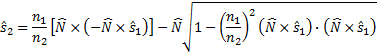

In [45]:
ns1 = torch.cross(normal, d, dim=1)

In [51]:
normal

tensor([[ 0.7583,  0.6519, -0.0000],
        [ 0.2026, -0.9793,  0.0000]])

In [65]:
normal*torch.sqrt(1-torch.pow(last_n/current_n, 2)*torch.einsum('bi,bi->b', ns1, ns1)).unsqueeze(1).repeat(1,3)

tensor([[ 0.7562,  0.6500, -0.0000],
        [ 0.1560, -0.7540,  0.0000]])

In [69]:
(last_n/current_n).unsqueeze(1).repeat(1,3) * (torch.cross(normal, torch.cross(-normal, d, dim=1), dim=1))

tensor([[ 0.0491, -0.0571,  0.0000],
        [-0.6249, -0.1293,  0.0000]])

In [66]:
last_n/current_n * (torch.cross(normal, torch.cross(-normal, d, dim=1), dim=1))

RuntimeError: The size of tensor a (2) must match the size of tensor b (3) at non-singleton dimension 1

In [70]:
new_dir = (last_n/current_n).unsqueeze(1).repeat(1,3) * (torch.cross(normal, torch.cross(-normal, d, dim=1), dim=1)) - normal * torch.sqrt(1-torch.pow(last_n/current_n, 2)*torch.einsum('bi,bi->b', ns1, ns1)).unsqueeze(1).repeat(1,3)

In [ ]:
new_dir

In [ ]:
def ray_step(direction, edge_vectors):
    d = torch.nn.functional.normalize(direction, dim=1)
    
    plane = torch.tensor([[0., 0., 1.]] * d.shape[0])
    normal = torch.cross(plane, edge_vectors, dim=1)
    normal = torch.nn.functional.normalize(normal, dim=1)
    
    normal_condition = torch.einsum('bi,bi->b', normal, d) > 0
    normal[normal_condition] = -normal[normal_condition]
    
    # Ley de Snell
    ns1 = torch.cross(normal, d, dim=1)
    ns1dot = torch.einsum('bi,bi->b', ns1, ns1).unsqueeze(1)
    mu = last_n / current_n
    new_dir = mu * (torch.cross(normal, torch.cross(-normal, d, dim=1), dim=1)) - normal * torch.sqrt(1-torch.pow(mu, 2)*ns1dot)
    return new_dir